In [1]:
import os
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Imputer
from sklearn.metrics import confusion_matrix, roc_curve,roc_auc_score,classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import *
import keras
from keras.preprocessing import sequence
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.layers import LSTM, Dense, Input, TimeDistributed, Masking
from keras.models import Model, Sequential
from keras.optimizers import RMSprop
from keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import itertools
import os
from keras.models import load_model
from sklearn.externals import joblib
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras import backend as K
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import *
import xgboost as xgb;

Using TensorFlow backend.


* This Dataset is from PHM 2018 data challenge: https://www.phmsociety.org/events/conference/phm/18/data-challenge
* you can get the raw data from: https://docs.google.com/uc?export=download&id=1WAnGFkeK7v54QLSP6MbE12N0d58cEPJE
* You can get re-engineered and sampled down sequnce data from: https://drive.google.com/open?id=1SYKOoxkFKQCx_BexammPqHhF9C3V5O-A

![]( Images/ionetch.png)

* ### The objective of the PHM challenge is to identify equipment faults and predict how long  before the next fault occurs

* ### The data set consists of :
> 1. #### 20 Ion Etching machines sensor data 
> 2. #### Fault labels for the 3 categories of fault along  with time of faults. There are over 1500 fault events


* ### We will focus on Equipment Fault classification in this notebook

### Sample sensor data from a machine

In [2]:
ex_table=pd.read_csv('phm_data_challenge_2018/train/03_M02_DC_train.csv')
ex_table.head()

,time,Tool,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,...,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION
0,3284714,03M02,1,640,10511726,249,1,-1.547961,-1.222222,-1.272007,...,-1.575525,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975
1,3284720,03M02,1,640,10511726,249,1,-1.547446,-1.221113,-1.272404,...,-1.575525,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975
2,3284722,03M02,1,640,10511726,249,1,-1.546922,-1.221020,-1.272007,...,-1.575525,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975
3,3284726,03M02,1,640,10511726,249,1,-1.547770,-1.221205,-1.271928,...,-1.575525,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975
4,3284730,03M02,1,640,10511726,249,1,-1.548045,-1.222407,-1.271769,...,-1.575525,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975


### Sample fault data file for the same machine

In [3]:
flt_table=pd.read_csv('phm_data_challenge_2018/train/train_faults/03_M02_train_fault_data.csv')
flt_table.head()

,time,fault_name,Tool
0,3326152,FlowCool Pressure Dropped Below Limit,03M02
1,3780688,FlowCool Pressure Dropped Below Limit,03M02
2,3961378,FlowCool Pressure Dropped Below Limit,03M02
3,4528896,FlowCool Pressure Dropped Below Limit,03M02
4,4528896,FlowCool Pressure Dropped Below Limit,03M02


# Time
> ## Machine
>> ### Processing Stage
>>> #### Wafer ID
>>>> #### Recipe (settings)
>>>>> #### Which step in the recipe

### What is RUL?
> - RUL is Remaining Useful Life: For machinery How many hours/cycles/miles before an event is going to happen

<img src="Images/multiRUL.png" style="width: 1200px;"/>

### Example of low pressure fault
<img src="Images/fault_example.png" style="width: 850px;"/>

### The problem with the Faults


In [4]:
flt_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361 entries, 0 to 360
Data columns (total 3 columns):
time          361 non-null int64
fault_name    361 non-null object
Tool          361 non-null object
dtypes: int64(1), object(2)
memory usage: 8.5+ KB


#### We start with 361 fault events for this machine

### After we join the fault labels with sensor data: How many faults do we see?

In [5]:
ex_table.join(flt_table[['time', 'fault_name']].set_index('time'),on='time',how='inner')

,time,Tool,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,...,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION,fault_name
405123,6187286,03M02,198,19070,10683894,143,5,-1.270369,-1.222222,-1.271848,...,-1.644976,1.363214,-0.00277,-0.178639,0,-0.806116,0.073280,-0.925916,0.667715,FlowCool Pressure Dropped Below Limit
679502,8147834,03M02,11,19036,10816408,143,5,-1.384396,-1.221760,-1.271451,...,-1.627224,1.363214,-0.00277,-0.178639,0,0.520729,0.671170,-0.188597,1.936362,FlowCool Pressure Dropped Below Limit
836253,9188844,03M02,1,1864,10883076,249,1,-1.549752,-1.221205,-1.271689,...,-1.625462,-0.772489,-0.00277,2.760125,0,-0.919727,1.004882,0.222937,4.367935,Flowcool Pressure Too High Check Flowcool Pump
983525,10298636,03M02,56,2928,10953940,143,5,0.337608,-0.059351,0.140687,...,0.613143,1.363214,-0.00277,-0.178639,0,-0.274433,1.304389,0.592290,-0.029079,FlowCool Pressure Dropped Below Limit
1522425,14448376,03M02,37,2045,11232373,143,3,0.416558,-0.058982,0.134015,...,0.661115,-0.696214,-0.00277,-0.178639,1,-0.698048,-1.340331,-0.869484,1.878696,FlowCool Pressure Dropped Below Limit
1876499,16949558,03M02,264,16749,11396558,255,13,-0.453819,-1.137251,-1.271610,...,-1.633457,1.363214,-0.00277,-0.178645,0,0.961269,-0.589958,0.055877,-0.149216,FlowCool Pressure Dropped Below Limit
2161660,19120120,03M02,0,10324,11540480,145,7,0.797664,1.497306,1.312121,...,0.673309,-1.077589,-0.00277,-0.178652,1,-1.181540,0.038066,-1.125980,6.655343,FlowCool Pressure Dropped Below Limit
2219460,19535422,03M02,16,9691,11568916,149,21,0.426433,-0.058706,0.143308,...,0.644581,-1.214884,-0.00277,5.804207,0,-0.909257,0.160751,-0.974685,-0.716263,Flowcool leak
2219970,19537706,03M02,0,4063,11568916,145,1,-1.547962,-1.222500,-1.272086,...,-1.657172,1.363214,-0.00277,-0.178639,0,-0.907670,0.161465,-0.973804,-0.000247,FlowCool Pressure Dropped Below Limit
2286811,20013840,03M02,21,19145,11601078,143,3,0.322425,-0.058982,0.141480,...,0.658674,-0.391113,-0.00277,-0.178645,1,-0.591058,0.304130,-0.797872,1.797003,FlowCool Pressure Dropped Below Limit


![]( Images/faultmatch.png)

#### We have to do fuzzy matching to line up fault labels with sensor data

## Data Engineering:
> ### Step 1: Insert each fault into it's machine data
> ### Setp 2: Break data into sequences belonging to recipe

# We have an unbalanced data set

* ### Only 1.5% of the data has faults, the rest is normal operation

* ### So a Classifier that misclassifies all faults can still get to 98.5% accuracy. 
> ### Chances of the aglorithm learning are pretty slim

![]( Images/black_swan.jpg)
#### This is a multi-rare event problem
#### We need to undersample to make this data set more balanced, How do we do that?

# VERY CAREFULLY

## We have some unique sequences that we need to preserve

## Time
> ### Machine
>> #### Processing Stage
>>> ##### Wafer ID
>>>> ##### Recipe (settings)
>>>>> ##### Which step in the recipe

### Normal Data is categorized around Recipe (settings)
> #### it's common to use Scikit Learn Stratified shuffle split function to perfom random splitting/undersampling, while preserving the distribution of the data

``` python

def split_data(xlist,series,nsplit,testsize,random=2301):
        trainsplit = StratifiedShuffleSplit(n_splits = nsplit ,  
                                            test_size = testsize ,
                                            random_state = random)
        
        """
        n_splits is for number of splits
        test_size is % size from the entire population
        random_state this is used to generate repeatable results
        """
        
        for train_index,test_index in trainsplit.split(series , 
                                                       series.values):        
            strat_train_set  =  series.loc [train_index ]
            strat_test_set  =  series.loc[test_index ]
        strat_train_X=[xlist[i] for i in train_index]
        strat_test_X=[xlist[i] for i in test_index ]
            
        """ 
        stratifying by classification variables
            
        """
        return strat_train_X,strat_test_X
```

#### Undersampling in this case was done by using early operations from a machine before faults and following a fault
> * ##### Given the uncertainty around the exact time of faults, this ensures the sampled down data set is using normal data, 

# This set was downsampled to ~17% of normal data
![]( Images/data1.png)

### Reading the lists of machine data

In [2]:
seq_list=os.listdir('lists/')
full_seq=[pickle.load(open('lists/{0}'.format(seq),'rb')) for seq in seq_list]

### Here's what each sequence has

In [3]:
'''
'seq','recipe_cat','has_fault','IONGAUGEPRESSURE','ETCHBEAMCURRENT','ETCHSUPPRESSORCURRENT',
'FLOWCOOLFLOWRATE','FLOWCOOLPRESSURE','no_fault','fault_name_FlowCool Pressure Dropped Below Limit',
'fault_name_Flowcool Pressure Too High Check Flowcool Pump', 'fault_name_Flowcool leak'
'''


"\n'seq','recipe_cat','has_fault','IONGAUGEPRESSURE','ETCHBEAMCURRENT','ETCHSUPPRESSORCURRENT',\n'FLOWCOOLFLOWRATE','FLOWCOOLPRESSURE','no_fault','fault_name_FlowCool Pressure Dropped Below Limit',\n'fault_name_Flowcool Pressure Too High Check Flowcool Pump', 'fault_name_Flowcool leak'\n"

#### The fault classifications are hot encoded

In [3]:
full_seq[0][0][0,:]

array([173125, 1, True, -1.3551443509829788, -1.1519091877593368,
       -1.1457896827297107, -1.4389063082864584, -1.218925743719081, 0, 1,
       0, 0], dtype=object)

### Each Sequence is 665 long

In [5]:
full_seq[0][0].shape

(665, 12)

### We have 40 sequence of sequences ( [normal &faulty] for each machine)

In [6]:
len(full_seq)

40

In [3]:
'''
This is putting all sequences in a single list
'''
seq_flat=[]
for i in range(len(full_seq)):
    seq_flat+=full_seq[i]

#### There are ~17,000 sequences of no fault data and 1500 sequences that contain 1 of 3 faults. This is more balanced now

In [8]:
len(seq_flat)

17596

In [9]:
seq_flat[0].shape

(665, 12)

### Enforcing data type and splitting into X and Y sequences

In [4]:
seqfl=[seq_flat[i][:,3:-4].astype('float32') for i in range(len(seq_flat))]
seqtarg=[seq_flat[i][0,-4:].astype('bool') for i in range(len(seq_flat))]

### Sequence Thinking
![]( Images/sequence.png)

### modeling distribution for each sequence
![]( Images/sequencedist.png)

In [5]:
distlist=[stats.describe(seqfl[i]) for i in range(len(seqfl))]
# This generates a distribution(Min, Max, Variance, etc.. ) for each sequence

In [6]:
distlist[0]

DescribeResult(nobs=665, minmax=(array([-1.3561918, -1.1535307, -1.1457896, -1.4494767, -1.2189257],
      dtype=float32), array([1.1624457 , 2.2707443 , 1.4160209 , 0.6921682 , 0.35360083],
      dtype=float32)), mean=array([-0.59616274, -0.45181343, -0.36726105, -0.68119395,  0.0336501 ],
      dtype=float32), variance=array([1.1083468 , 1.0430305 , 1.3138739 , 1.0510769 , 0.21769631],
      dtype=float32), skewness=array([ 0.7009401 ,  0.79832065,  0.803976  ,  0.5860452 , -1.813753  ],
      dtype=float32), kurtosis=array([-1.4918975, -1.313417 , -1.3331847, -1.6565182,  1.7766485],
      dtype=float32))

#### We will stack each statistics next to each so that for each sequence we have the following new features generated
![]( Images/distrib.png)

In [7]:
distarrlist=[np.hstack(np.asarray((distlist[i].minmax[0],distlist[i].minmax[1],distlist[i].mean,distlist[i].variance,
                               distlist[i].kurtosis,seqtarg[i]))) for i in range(len(distlist))]

In [8]:
distarr=np.vstack(distarrlist)

In [14]:
distarr.shape

(17596, 29)

# Revisiting The target variable

In [9]:
Y=[seq_flat[seq][0,-4:] for seq in range(len(seq_flat))]

In [10]:
Y[0]

array([0, 1, 0, 0], dtype=object)

In [11]:
# removing hot encoding/combining into one column so we can stratify 
for fault in range(len(Y)):
    if Y[fault][0]==1:
        Y[fault]='n_fault'
    elif Y[fault][1]==1:
        Y[fault]='FlowCool Pressure Dropped Below Limit'
    elif Y[fault][2]==1:
        Y[fault]='Flowcool Pressure Too High Check Flowcool Pump'
    else:
        Y[fault]='Flowcool leak'

In [12]:
Y[0]

'FlowCool Pressure Dropped Below Limit'

In [13]:
Y=np.asarray(Y)
# Reshaping Y to be nx1 matrix
Y=Y.reshape(-1,1)

In [14]:
X=distarr[:,:-4]

In [15]:
dfX=pd.DataFrame(X).join(pd.DataFrame(Y,columns=['fault']))
dfX

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,fault
0,-1.356192,-1.153531,-1.145790,-1.449477,-1.218926,1.162446,2.270744,1.416021,0.692168,0.353601,...,1.043031e+00,1.313874,1.051077,0.217696,-1.491897,-1.313417,-1.333185,-1.656518,1.776649,FlowCool Pressure Dropped Below Limit
1,-1.356506,-1.152247,-1.145790,-1.449477,-1.218926,1.168048,2.350862,1.515171,0.692168,0.417530,...,6.342565e-01,0.857417,0.702629,0.092568,0.899762,1.642895,1.547274,0.395018,10.854395,FlowCool Pressure Dropped Below Limit
2,-1.353839,-1.153531,-1.145790,-1.449477,-1.218926,1.050444,3.273169,0.799128,2.418428,0.498565,...,2.416486e-01,0.405298,1.180879,0.370918,-1.605065,28.241505,-1.198013,-1.762679,-1.036227,FlowCool Pressure Dropped Below Limit
3,-1.354473,-1.152585,-1.145790,-1.449477,-1.218926,1.093382,3.135396,0.816852,0.690783,0.349931,...,3.195890e-01,0.412884,1.150533,0.487521,-1.586265,25.352356,-1.122127,-1.992062,-1.872281,FlowCool Pressure Dropped Below Limit
4,-1.354647,-1.152517,-1.145790,-1.449477,-1.218926,1.020579,0.608564,0.690126,0.688267,0.349117,...,1.701206e-01,0.398531,1.149942,0.472118,-1.639243,0.441737,-1.180675,-1.995597,-1.816243,FlowCool Pressure Dropped Below Limit
5,-1.356606,-1.152585,-1.145790,-1.449477,-1.218926,1.182045,1.081974,1.581161,0.694685,0.360112,...,2.306716e-01,0.314442,0.272134,0.046905,12.310758,14.408663,14.488758,10.769720,26.409027,FlowCool Pressure Dropped Below Limit
6,-1.354449,-1.152382,-1.145790,-1.449477,-1.218926,1.119507,0.066106,0.653355,0.971782,0.350345,...,1.384521e-01,0.374595,1.152883,0.467945,-1.611095,-0.739243,-1.050697,-1.978319,-1.823362,FlowCool Pressure Dropped Below Limit
7,-1.354416,-1.152382,-1.145790,-1.449477,-1.218926,1.125117,2.286756,0.651711,1.640599,0.354415,...,2.475294e-01,0.379412,1.178878,0.461015,-1.589184,15.065102,-1.124579,-1.909956,-1.803673,FlowCool Pressure Dropped Below Limit
8,-1.354598,-1.152315,-1.145790,-1.449477,-1.218926,1.047643,2.654141,0.956718,0.693803,0.369893,...,9.760498e-01,0.827117,0.779720,0.311890,-0.600266,-1.005531,-1.090275,-0.136700,0.390924,Flowcool Pressure Too High Check Flowcool Pump
9,-1.356387,-1.152787,-1.145790,-1.449477,-1.218926,1.191379,1.084474,1.151730,0.693050,0.367038,...,1.112705e+00,1.124055,0.915831,0.380306,-1.366846,-1.690802,-1.678474,-1.015092,-0.620430,FlowCool Pressure Dropped Below Limit


In [16]:
def split_data(data_df,category,nsplit,testsize,random=2301):
    trainsplit  =  StratifiedShuffleSplit ( n_splits = nsplit ,  test_size = testsize ,  random_state = random )
    
    """
    n_splits is for number of splits
    test_size is % size from the entire population(between 0 and 1) for the test data set
    random_state this is used to generate repeatable results next time we run this code again
    """
    for  train_index ,  test_index  in  trainsplit . split ( data_df ,  data_df[category]):
        strat_train_set  =  data_df.loc [train_index ]
        strat_test_set  =  data_df.loc[test_index ]
        
    """ 
    stratifying by classification variables
        
    """
    return strat_train_set,strat_test_set

In [17]:
train_df,test_df =split_data(data_df=dfX,category=["fault"],nsplit=1,testsize=0.1)

X_train=train_df.iloc[:,:-1].values

X_test=test_df.iloc[:,:-1].values
y_train=train_df["fault"].values
y_test=test_df["fault"].values;

## Testing out balanced weight class to see if the classifier learns more

In [18]:
ranf_clf=RandomForestClassifier(n_estimators=500,random_state=2301,n_jobs=-1,class_weight='balanced')

In [19]:
ranf_clf=ranf_clf.fit(X_train, y_train)

In [20]:
scores = cross_val_score(ranf_clf, X_train, y_train,n_jobs=-1, cv=5)
scores

array([0.97096876, 0.97127525, 0.97380051, 0.97504738, 0.97661927])

In [21]:
test_pred_xgb=ranf_clf.predict(X_test)
acc_test=accuracy_score(y_test,test_pred_xgb)
confusion = confusion_matrix(y_test, test_pred_xgb)
print("accuracy:\n{}".format(acc_test))
print("Confusion matrix:\n{}".format(confusion))

accuracy:
0.9642045454545455
Confusion matrix:
[[ 116   13    0   14]
 [  10   19    0    9]
 [   3    0    3    8]
 [   6    0    0 1559]]


Normalized confusion matrix


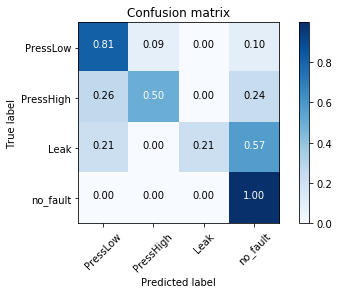

In [23]:
plot_confusion_matrix(confusion,classes=['PressLow','PressHigh','Leak','no_fault'],normalize=True)

In [24]:
ranf_clf=RandomForestClassifier(n_estimators=500,random_state=2301,n_jobs=-1)

In [25]:
ranf_clf=ranf_clf.fit(X_train, y_train)

In [26]:
scores = cross_val_score(ranf_clf, X_train, y_train,n_jobs=-1, cv=5)
scores

array([0.97601767, 0.97569444, 0.97506313, 0.97599495, 0.97977883])

In [27]:
test_pred_xgb=ranf_clf.predict(X_test)
acc_test=accuracy_score(y_test,test_pred_xgb)
confusion = confusion_matrix(y_test, test_pred_xgb)
print("accuracy:\n{}".format(acc_test))
print("Confusion matrix:\n{}".format(confusion))

accuracy:
0.96875
Confusion matrix:
[[ 121   12    0   10]
 [   7   24    0    7]
 [   3    0    3    8]
 [   8    0    0 1557]]


## Training a classifier with the class weight setting=None outperforms balancing the weights

Normalized confusion matrix


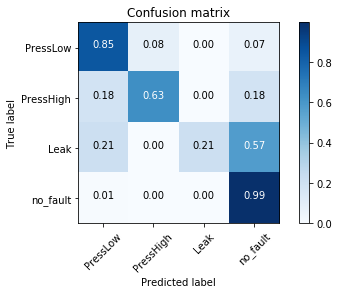

In [28]:
plot_confusion_matrix(confusion,classes=['PressLow','PressHigh','Leak','no_fault'],normalize=True)

### Baselining with softmax Classifier for No Fault and the multlipe faults

In [62]:
'''
- Setting hyperparameters for xgboost, 
adjust number of trees range between 10 and 700 and learning rate from 0.01 to 0.4
Call Classifier, seed=2301
- use CV=5 for GridSearch
'''
params={'n_estimators':[100,500,1000],'max_depth':[3,30,300]}
xgb_clf=xgb.XGBClassifier(random_state=2301,n_jobs=-1)
gs_xgb_clf=GridSearchCV(estimator=xgb_clf,param_grid=params,cv=5,return_train_score=False)

In [63]:
'''
- We will now fit the model and predict the training data set
'''
gs_xgb_clf=gs_xgb_clf.fit(X_train, y_train)

In [64]:
gs_xgb_clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=30, min_child_weight=1, missing=None,
       n_estimators=500, n_jobs=-1, nthread=None,
       objective='multi:softprob', random_state=2301, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [65]:
scores = cross_val_score(gs_xgb_clf.best_estimator_, X_train, y_train,n_jobs=-1, cv=5)
scores

array([0.97822657, 0.97727273, 0.97758838, 0.97536323, 0.98104265])

In [66]:
test_pred_xgb=gs_xgb_clf.predict(X_test)
acc_test=accuracy_score(y_test,test_pred_xgb)
confusion = confusion_matrix(y_test, test_pred_xgb)
print("accuracy:\n{}".format(acc_test))
print("Confusion matrix:\n{}".format(confusion))

accuracy:
0.9704545454545455
Confusion matrix:
[[ 124   11    1    7]
 [   8   23    0    7]
 [   4    0    3    7]
 [   7    0    0 1558]]


In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


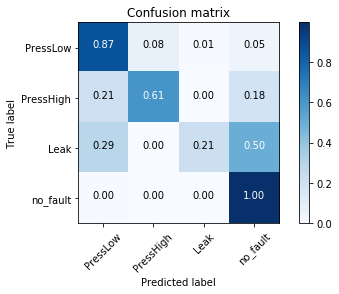

In [68]:
plot_confusion_matrix(confusion,classes=['PressLow','PressHigh','Leak','no_fault'],normalize=True)

### High Pressure and Leak Faults classifications need improvement

### The 2nd technique to improve imbalance:
> #### Stack up our Classifiers to learn Normal from Faulty and then let another classifier specialize in the faulty dataset only. 
<img src="Images/classifiers.png" style="height: 450px;"/>

### Learning the boundaries
<img src="Images/boundaries.png"/>

In [ ]:
# ADDING A A FAULT OR NO FAULT LABEL FOR THE FIRST CLASSIFIER
dfX['fault_bin']=dfX['fault'].apply(lambda x: 'normal' if x=='n_fault' else 'fault')

In [70]:
dfX

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,fault,fault_bin
0,-1.356192,-1.153531,-1.145790,-1.449477,-1.218926,1.162446,2.270744,1.416021,0.692168,0.353601,...,1.313874,1.051077,0.217696,-1.491897,-1.313417,-1.333185,-1.656518,1.776649,FlowCool Pressure Dropped Below Limit,fault
1,-1.356506,-1.152247,-1.145790,-1.449477,-1.218926,1.168048,2.350862,1.515171,0.692168,0.417530,...,0.857417,0.702629,0.092568,0.899762,1.642895,1.547274,0.395018,10.854395,FlowCool Pressure Dropped Below Limit,fault
2,-1.353839,-1.153531,-1.145790,-1.449477,-1.218926,1.050444,3.273169,0.799128,2.418428,0.498565,...,0.405298,1.180879,0.370918,-1.605065,28.241505,-1.198013,-1.762679,-1.036227,FlowCool Pressure Dropped Below Limit,fault
3,-1.354473,-1.152585,-1.145790,-1.449477,-1.218926,1.093382,3.135396,0.816852,0.690783,0.349931,...,0.412884,1.150533,0.487521,-1.586265,25.352356,-1.122127,-1.992062,-1.872281,FlowCool Pressure Dropped Below Limit,fault
4,-1.354647,-1.152517,-1.145790,-1.449477,-1.218926,1.020579,0.608564,0.690126,0.688267,0.349117,...,0.398531,1.149942,0.472118,-1.639243,0.441737,-1.180675,-1.995597,-1.816243,FlowCool Pressure Dropped Below Limit,fault
5,-1.356606,-1.152585,-1.145790,-1.449477,-1.218926,1.182045,1.081974,1.581161,0.694685,0.360112,...,0.314442,0.272134,0.046905,12.310758,14.408663,14.488758,10.769720,26.409027,FlowCool Pressure Dropped Below Limit,fault
6,-1.354449,-1.152382,-1.145790,-1.449477,-1.218926,1.119507,0.066106,0.653355,0.971782,0.350345,...,0.374595,1.152883,0.467945,-1.611095,-0.739243,-1.050697,-1.978319,-1.823362,FlowCool Pressure Dropped Below Limit,fault
7,-1.354416,-1.152382,-1.145790,-1.449477,-1.218926,1.125117,2.286756,0.651711,1.640599,0.354415,...,0.379412,1.178878,0.461015,-1.589184,15.065102,-1.124579,-1.909956,-1.803673,FlowCool Pressure Dropped Below Limit,fault
8,-1.354598,-1.152315,-1.145790,-1.449477,-1.218926,1.047643,2.654141,0.956718,0.693803,0.369893,...,0.827117,0.779720,0.311890,-0.600266,-1.005531,-1.090275,-0.136700,0.390924,Flowcool Pressure Too High Check Flowcool Pump,fault
9,-1.356387,-1.152787,-1.145790,-1.449477,-1.218926,1.191379,1.084474,1.151730,0.693050,0.367038,...,1.124055,0.915831,0.380306,-1.366846,-1.690802,-1.678474,-1.015092,-0.620430,FlowCool Pressure Dropped Below Limit,fault


In [71]:
train_df,test_df =split_data(data_df=dfX,category=["fault_bin"],nsplit=1,testsize=0.1)

X_train=train_df.iloc[:,:-2].values

X_test=test_df.iloc[:,:-2].values
y_train=train_df["fault_bin"].values
y_test=test_df["fault_bin"].values;

In [73]:
'''
- We will now fit the model and predict the training data set
'''
xgb_clf_bin=xgb.XGBClassifier(n_estimators=500, n_jobs=-1, random_state=2301, max_depth=30)
xgb_clf_bin=xgb_clf_bin.fit(X_train, y_train)

In [75]:
scores = cross_val_score(xgb_clf_bin, X_train, y_train,n_jobs=-1, cv=5)
scores

array([0.98642677, 0.98673824, 0.98958004, 0.98800126, 0.98926429])

In [76]:
test_pred_xgb=xgb_clf_bin.predict(X_test)
acc_test=accuracy_score(y_test,test_pred_xgb)
confusion = confusion_matrix(y_test, test_pred_xgb)
print("accuracy:\n{}".format(acc_test))
print("Confusion matrix:\n{}".format(confusion))

accuracy:
0.9818181818181818
Confusion matrix:
[[ 173   22]
 [  10 1555]]


Normalized confusion matrix


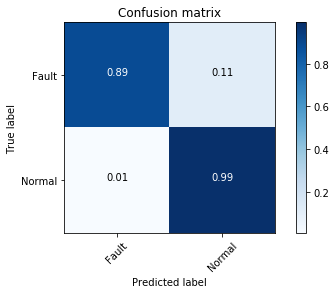

In [77]:
plot_confusion_matrix(confusion,classes=['Fault','Normal'],normalize=True)

* 90% accurate on recognizing faulty sequences

#### Building a 2nd classifier to recognize the different types of Fault

In [78]:
dfXt=dfX[dfX['fault_bin']=='fault'].reset_index(drop=True)

In [79]:
train_df,test_df =split_data(data_df=dfXt,category=["fault"],nsplit=1,testsize=0.1)

X_train=train_df.iloc[:,:-2].values

X_test=test_df.iloc[:,:-2].values
y_train=train_df["fault"].values
y_test=test_df["fault"].values;

In [86]:
xgb_clf_flt=xgb.XGBClassifier(n_estimators=500, n_jobs=-1, random_state=2301)

In [87]:
'''
- We will now fit the model and predict the training data set
'''
xgb_clf_flt=xgb_clf_flt.fit(X_train, y_train)

In [88]:
scores = cross_val_score(xgb_clf_flt, X_train, y_train,n_jobs=-1, cv=5)
scores

array([0.83806818, 0.88920455, 0.84943182, 0.89428571, 0.88252149])

In [89]:
test_pred_xgb=xgb_clf_flt.predict(X_test)
acc_test=accuracy_score(y_test,test_pred_xgb)
confusion = confusion_matrix(y_test, test_pred_xgb)
print("accuracy:\n{}".format(acc_test))
print("Confusion matrix:\n{}".format(confusion))

accuracy:
0.8923076923076924
Confusion matrix:
[[132  11   0]
 [  7  31   0]
 [  3   0  11]]


Normalized confusion matrix


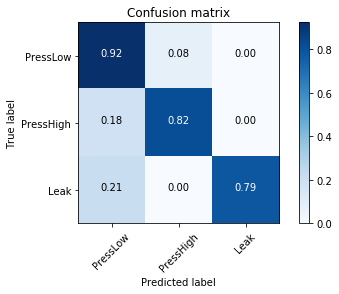

In [90]:
plot_confusion_matrix(confusion,classes=['PressLow','PressHigh','Leak'],normalize=True)

**Did we beat the single Classifier we built earlier?**
<img src="Images/singleclassfify.png"/>